In [1]:
import pandas as pd
import numpy as np
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-03-10 23:18:19.427819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 23:18:19.581860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741628899.673975  120192 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741628899.698319  120192 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 23:18:19.851271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load dataset
df = pd.read_excel("/home/fariz/Works/Malayalam-Emotion-Detector/github_test/Emotions data.xlsx")

In [3]:

# Ensure dataset has the necessary columns
print("Dataset columns:", df.columns)


X = df['Text'].tolist()
y = df['Emotion']

Dataset columns: Index(['Text', 'Emotion'], dtype='object')


In [4]:
# Load trained BERT model and tokenizer
bert_model_path = "./bert_emotion_model"
tokenizer = BertTokenizer.from_pretrained(bert_model_path)
bert_model = BertModel.from_pretrained(bert_model_path)

In [5]:
# Function to extract BERT embeddings
def get_bert_embeddings(text_list, tokenizer, model):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in text_list:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Extract BERT embeddings
X_embeddings = get_bert_embeddings(X, tokenizer, bert_model)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Train Gaussian Naïve Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

In [7]:
# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Abusive       0.20      0.03      0.05       189
       Anger       0.13      0.23      0.17       205
  Excitement       0.17      0.04      0.06       217
        Fear       0.27      0.09      0.14       211
       Happy       0.17      0.02      0.03       195
      Humour       0.13      0.64      0.21       192
        Love       0.16      0.24      0.19       174
         Sad       0.17      0.12      0.14       198
     Sarcasm       0.16      0.05      0.08       208
    Surprise       0.31      0.04      0.07       211

    accuracy                           0.15      2000
   macro avg       0.19      0.15      0.11      2000
weighted avg       0.19      0.15      0.11      2000



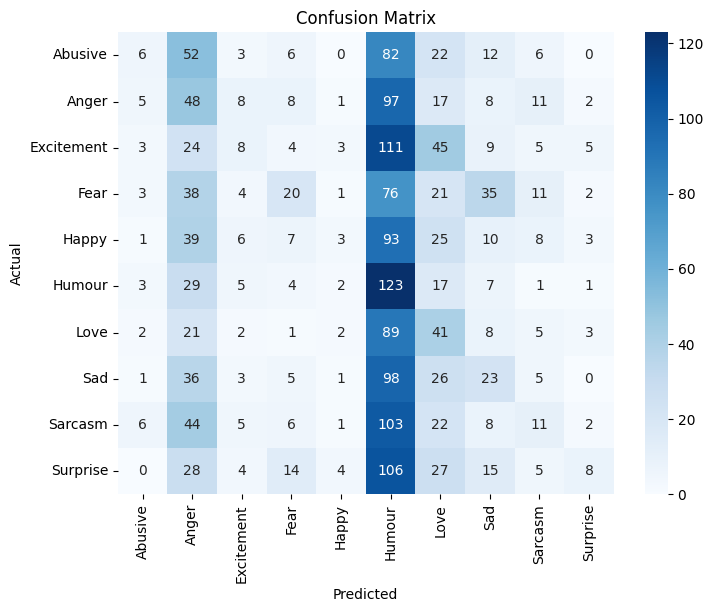

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Save trained model and BERT tokenizer for future use
joblib.dump(clf, "malayalam_text_classifier.pkl")
joblib.dump(X_embeddings, "bert_embeddings.pkl")
tokenizer.save_pretrained("bert_tokenizer")

print("Model, tokenizer, and embeddings saved successfully!")

Model, tokenizer, and embeddings saved successfully!
